In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import join
import pickle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedKFold, ShuffleSplit
from sklearn.pipeline import Pipeline
from pyemma.coordinates.clustering import NDGrid
from pyemma.msm import MaximumLikelihoodMSM
import warnings 
warnings.filterwarnings(action='ignore')


In [2]:
8440/128

65.9375

In [3]:
def bootstrap_ci(x, ci=(0.05,.95), n_boot=1000):
    medians = []
    for i in range(n_boot):
        medians.append(np.median(np.random.choice(x,size=x.shape[0], replace=True)))
    medians = np.sort(np.array(medians))
    return medians[int(ci[0]*n_boot)], medians[int(ci[1]*n_boot)]


In [4]:
stride=10
lag = 30
lag_in_strides = int(lag/stride)

In [5]:
paths = ['data/100.0pc/quad_well_{:02d}.npy'.format(x) for x in range(100)]
# paths
X1 = [np.load(x) for x in paths]

len(X1)
X1[0].shape

(84401, 1)

In [6]:
X1 = [x[::stride,:] for x in X1]

In [7]:
X2 = [y for x in X1 for y in np.array_split(x,2)]
X4 = [y for x in X1 for y in np.array_split(x,4)]
X8 = [y for x in X1 for y in np.array_split(x,8)]
X16 = [y for x in X1 for y in np.array_split(x,16)]
X32 = [y for x in X1 for y in np.array_split(x,32)]
X64 = [y for x in X1 for y in np.array_split(x,64)]
X128 = [y for x in X1 for y in np.array_split(x,128)]

In [8]:
data = {'1-Splits': X1, '2-Splits': X2, '4-Splits':  X4, '8-Splits': X8, '16-Splits': X16, 
       '32-Splits': X32,'64-Splits': X64, '128-Splits': X128}

In [9]:
model = Pipeline([('cluster', NDGrid(min=-1.2, max=1.2, n_bins_per_feature=200)),
                   ('msm', MaximumLikelihoodMSM(lag=lag_in_strides,score_method='vampe', score_k=2))])

In [10]:
cv = ShuffleSplit(test_size=0.5, n_splits=10)

In [11]:
ms = list(np.logspace(np.log10(10), np.log10(1000), 5).astype(int))
print(ms)


[10, 31, 100, 316, 1000]


In [12]:
search = GridSearchCV(model, cv=cv, param_grid={'cluster__n_bins_per_feature': ms} )

In [13]:
results = {}
for k, v in data.items():
    print(k)
    search.fit(v)
    results[k] = pd.DataFrame(search.cv_results_)

2-Splits
4-Splits
1-Splits
16-Splits
128-Splits
32-Splits
8-Splits
64-Splits


In [ ]:
# results['All-Splits'] = pd.DataFrame(search.cv_results_)

In [14]:
all_dfs = []
for nsplits, df  in results.items():
    fold_dfs = []
    id_var = list(df.filter(regex='param_', axis=1).columns)[0]
    for fold in ['test', 'train']:
        fold_df = df.filter(regex='split[0-9]_{}|param_'.format(fold), axis=1)
        fold_df = pd.melt(frame=fold_df, id_vars=id_var, var_name='fold', value_name='VAMP-E')
        fold_df['fold'] = fold
        fold_df['n_traj_splits'] = nsplits
        fold_dfs.append(fold_df)
    all_dfs.append(pd.concat(fold_dfs))
df = pd.concat(all_dfs)
    
    

In [15]:
df.shape

(800, 4)

In [109]:
df.sort_values(by='param_cluster__n_bins_per_feature', inplace=True)

In [120]:
df['Splits'] = df['n_traj_splits'].apply(lambda x: int(x.split('-')[0]))
df.head()

,param_cluster__n_bins_per_feature,fold,VAMP-E,n_traj_splits,Splits
0,10,train,1.925836,8-Splits,8
30,10,test,1.926068,64-Splits,64
35,10,test,1.926001,64-Splits,64
30,10,test,1.925201,4-Splits,4
20,10,train,1.927039,16-Splits,16


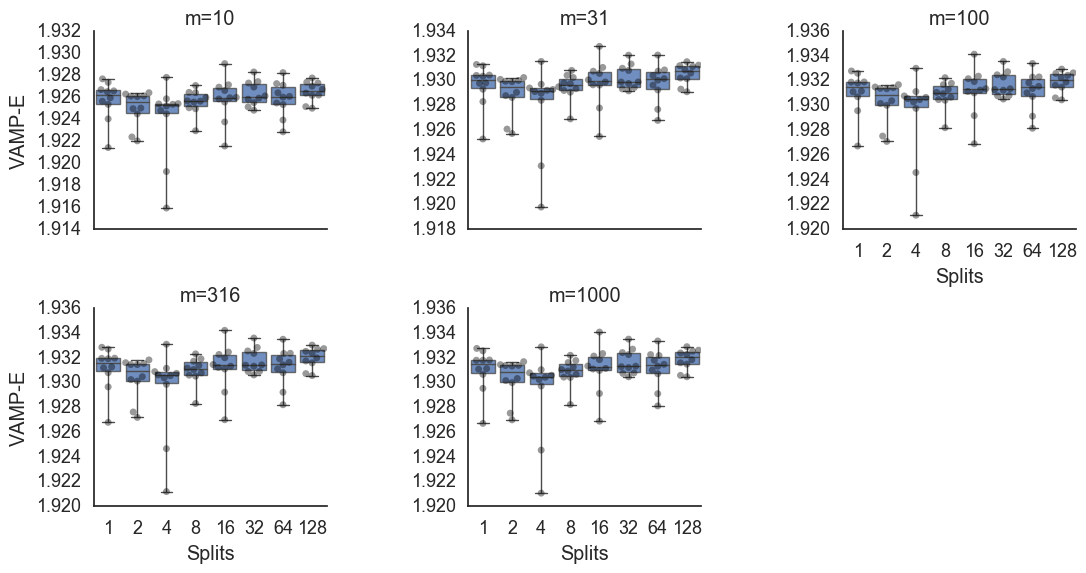

In [124]:
# from matplotlib.ticker import FuncFormatter, MaxNLocator
# def format_fn(tick_val, tick_pos):
#     try:
#         return 2**tick_val
#     except:
#         return ''
    
with sns.plotting_context('talk', font_scale=1):
    sns.set_style('white')
    g = sns.FacetGrid(data=df.loc[df['fold']=='test',:],  col='param_cluster__n_bins_per_feature', 
                      aspect=1.3, sharey=False, col_wrap=3)
    g.map(sns.boxplot, 'Splits', 'VAMP-E', saturation=1, linewidth=1,
          whis=20, boxprops=dict(alpha=.8),)
    g.map(sns.swarmplot, 'Splits', 'VAMP-E', color='k', alpha=0.4)
#     g.set(xlabel='Splits')
    g.set_titles('m={col_name}')
#     for ax in g.axes.flatten():
#         ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    plt.savefig('figures/traj_splits_vs_score.png', transparent=True)

In [103]:
cv.n_splits=50
model.set_params(cluster__n_bins_per_feature=100)
scores = cross_val_score(X=X8,cv=cv, estimator=model)

In [104]:
n_splits = np.arange(5,51,5)
n_cis = [bootstrap_ci(scores[:n]) for n in n_splits]
n_cis = [y - x for x,y in n_cis]
n_meds = [np.median(scores[:n]) for n in n_splits]

In [105]:
n_cis

[0.003285888926629843,
 0.0022456497362417505,
 0.0022456497362417505,
 0.0021850977946560324,
 0.0016429764676157976,
 0.00141705017020044,
 0.0010946562864937448,
 0.0009926479106159292,
 0.0006793166379241988,
 0.000879741896087749]

In [106]:
n_scores = [ x for n in n_splits for x in scores[:n]]


df_scores = pd.DataFrame(data={'n_splits': [ x  for n in n_splits for x in [n]*n], 'VAMP-E': n_scores})
df_scores.shape

(275, 2)

In [107]:
cols = sns.color_palette('colorblind',3)

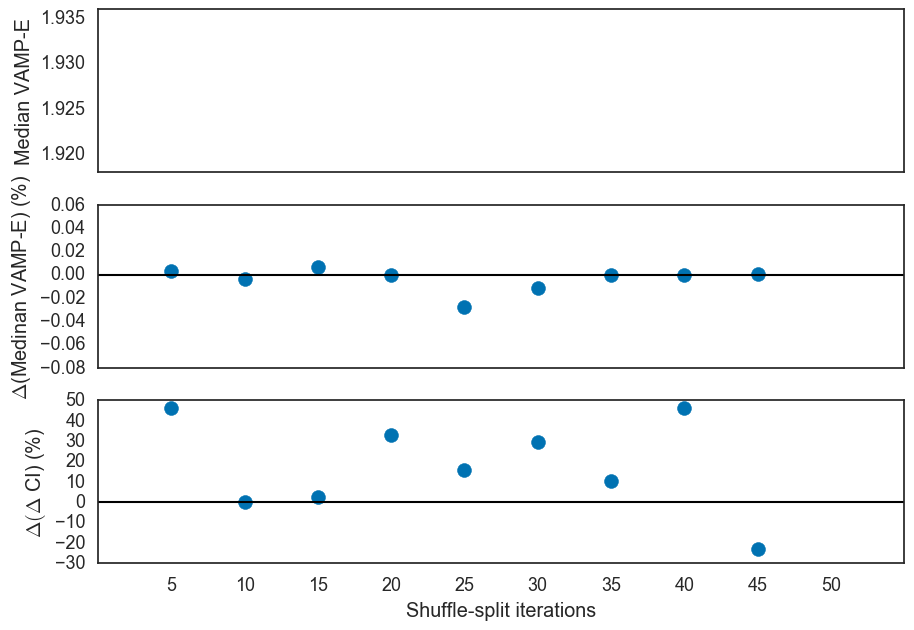

In [108]:
with sns.plotting_context('talk', font_scale=1):
    fig, axes = plt.subplots(3,sharex=True)
    
    ##
    ax = axes[0]
    sns.pointplot(data=df_scores, x='n_splits', y='VAMP-E', ci=None, 
                  join=False, estimator=np.median, color=cols[0], label='Median CV', ax=ax)
    sns.stripplot(data=df_scores, x='n_splits', y='VAMP-E',color=cols[0], alpha=0.5, ax=ax)
    ax.set_ylabel('Median VAMP-E')
    ax.set_xlabel('')
    ax.set_ylim((1.918,1.936))
    
    ##
    ax = axes[1]
    n = n_splits.shape[0]-1
    ax.scatter(np.arange(n), 100*(np.array(n_meds[:-1])/np.array(n_meds[1:])-1), color=cols[0], s=100)
    ax.hlines(0,-1,n+1, color='k', lw=1.5)
    
#     ax.xlabels(n_splits[:-1])
    ax.set_xlim(-1,n+1)
    ax.set_ylabel('$\Delta$(Medinan VAMP-E) (%)')
    
    ax = axes[2]
    ax.scatter(np.arange(n), 100*(np.array(n_cis[:-1])/np.array(n_cis[1:])-1), color=cols[0], s=100)
    ax.hlines(0,-1,n+1, color='k', lw=1.5)
    
#     ax.xlabels(n_splits[:-1])
    ax.set_xlim(-1,n+1)
    ax.set_ylabel('$\Delta(\Delta$ CI) (%)')
    ax.set_xlabel('Shuffle-split iterations')
    
    plt.savefig('figures/CV_scores_vs_n_splits.png', transparent=True)
    

In [125]:
## Splits &  Iterations vs VAMPE

In [ ]:
cv.n_splits=50
model.set_params(cluster__n_bins_per_feature=100)
scores = cross_val_score(X=X8,cv=cv, estimator=model)